# Loading data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import datetime
import pickle
import time
import os
import pathlib
import matplotlib.pyplot as plt
import sys
import shutil
 
# Some stuff to make utils-function work
sys.path.append('../utils')
from pipeline import *
from create_model import *
from utils import *
from unlabeled_utils import *
from evaluate_model import *
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

project_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Some parameters

In [2]:
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-capsule/labeled_ttv/')
unlab_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-capsule/unlabeled_ttv/')

conf = {
    # Dataset
    "data_dir": data_dir,
    "unlab_dir": unlab_dir,
    "ds_info": 'binary',
    "augment": ["crop","flip","brightness","saturation","contrast","rotate"],
    "aug_mult": 0.4,
    "resample": True,
    "class_weight": False,
    "shuffle_buffer_size": 2000,       # 0=no shuffling
    "seed": 2511,
    "neg_class": "Normal",                 # select neg class for binary ds (normal class)
    "outcast": None,                   # list of folders to drop - currently only works for 1 item
    # Model
    "model": 'EfficientNetB0',
    "weights": "imagenet",             # which weights to initialize the model with
    "dropout": 0.2,
    "num_epochs": 3,
    "batch_size": 16,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.001,
    "optimizer": 'Adam',
    "final_activation": 'softmax',     # sigmoid for binary ds
    # Callbacks
    "tensorboard": False,
    "decay_rate": 0,                   # 128:0.25   64:1.0   32:4.0   16:16   8:64
    "checkpoint": False,
    "early_stopp_patience": 0,         # disable: 0
    # Misc
    "verbosity": 1,
    "keep_thresh": 0.9,                # probability threshold for inferring pseudo labels
    "pseudo_thresh": 4000,
    "cache_dir": "./cache",
    }

In [3]:
def run_iteration(conf, ds, datasets_bin, sanity):
    """
    """
    model = create_model(conf)
    callbacks = create_callbacks(conf)
    class_weights = get_class_weights(ds["train"], conf)

    start_time = time.time()
    history = model.fit(
            ds["train"],
            steps_per_epoch = conf["steps"]["train"],
            epochs = conf["num_epochs"],
            validation_data = ds["test"],
            validation_steps = conf["steps"]["test"],
            validation_freq = 1,
            class_weight = class_weights,
            callbacks = callbacks,
            verbose = 1
    )
    if conf["verbosity"]:
        print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

    if conf["num_epochs"] > 9:
        model.save(conf["log_dir"]+'/model')

    evaluate_model(model, history, ds, conf)

    count = {"findings": 0, "total": 0}
    pseudo = {"pred_list": [], "lab_list": [], "name_list": []}

    pseudo, count = generate_labels(pseudo, count, ds["unlab"], model, conf)
    
    # Sort in order of highest confidence to lowest
    pseudo_sorted = custom_sort(pseudo)

    checkout_findings(pseudo_sorted, conf, show=False)

    datasets_bin, added_samples = resample_and_combine(ds, conf, pseudo, pseudo_sorted, datasets_bin)

    # Update unlab_ds
    ds["unlab"] = reduce_dataset(ds["unlab"], remove=added_samples)
    
    sanity, conf = update_sanity(sanity, len(added_samples), datasets_bin, conf)

In [4]:
teacher = {
    "name": "teacher",
    "model": "EfficientNetB0",
    "aug_mult": 0.1,
    "dropout": 0.1
}

student = {
    "name": "student",
    "model": "EfficientNetB0",
    "aug_mult": 0.8,
    "dropout": 0.2
}

models_list = [teacher, student]

In [6]:
!rm -r ./cache/128_resampled*


#### 0_teacher ####


Negative                          : 33449 | 71.10%
---------------------------------------------
     - Normal                     : 33449 | 71.10%

Positive                          : 13596 | 28.90%
---------------------------------------------
     - Polyp                      :    65 | 0.14%
     - Reduced Mucosal View       :  2399 | 5.10%
     - Mucosa                     :  1157 | 2.46%
     - Unknown                    :    87 | 0.18%
     - Lymphoid Hyperplasia       :   518 | 1.10%
     - Foreign Bodies             :   776 | 1.65%
     - Ulcer                      :   854 | 1.82%
     - Erosion                    :   439 | 0.93%
     - Pylorus                    :  1529 | 3.25%
     - Ileo-cecal valve           :  4189 | 8.90%
     - Blood                      :   446 | 0.95%
     - Angiectasia                :   866 | 1.84%
     - Hematin                    :    12 | 0.03%
     - Erythematous               :   259 | 0.55%

Total number of image       : 

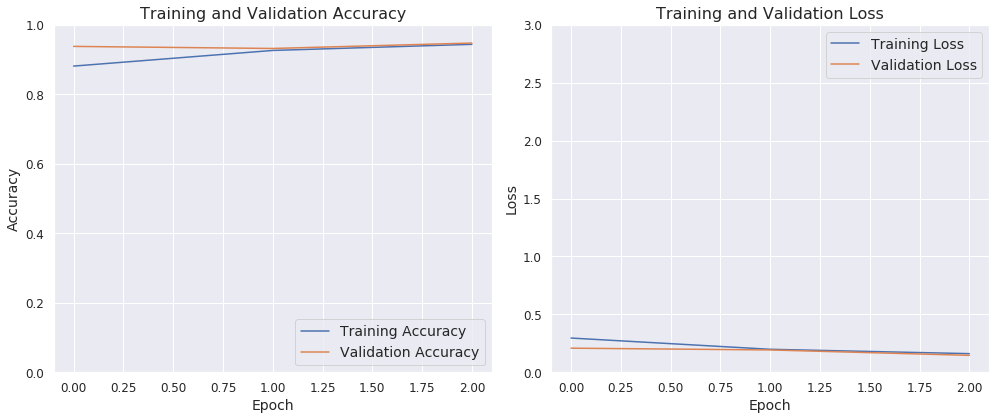

441/441 - 5s - loss: 0.1493 - sparse_categorical_accuracy: 0.9480
7063/7063 [==============================] - 5s 719us/sample
              precision    recall  f1-score   support

    Negative      0.987     0.939     0.963      5018
    Positive      0.867     0.969     0.915      2045

    accuracy                          0.948      7063
   macro avg      0.927     0.954     0.939      7063
weighted avg      0.952     0.948     0.949      7063



Press 'Interrupt Kernel' to save and exit.


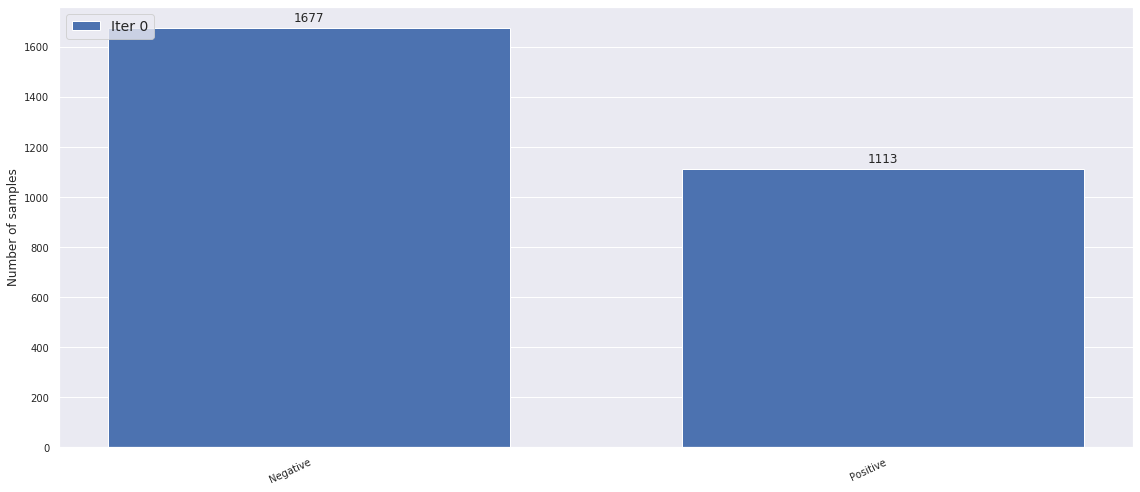


Total run time: 1.9 min.
Found 2790 new samples in unlabeled_ds after looking at 4001 images.
Limit set by Negative with 23414 samples
----------------------------------------
Negative                   : added 0/1677 samples.
Positive                   : added 1113/1113 samples.


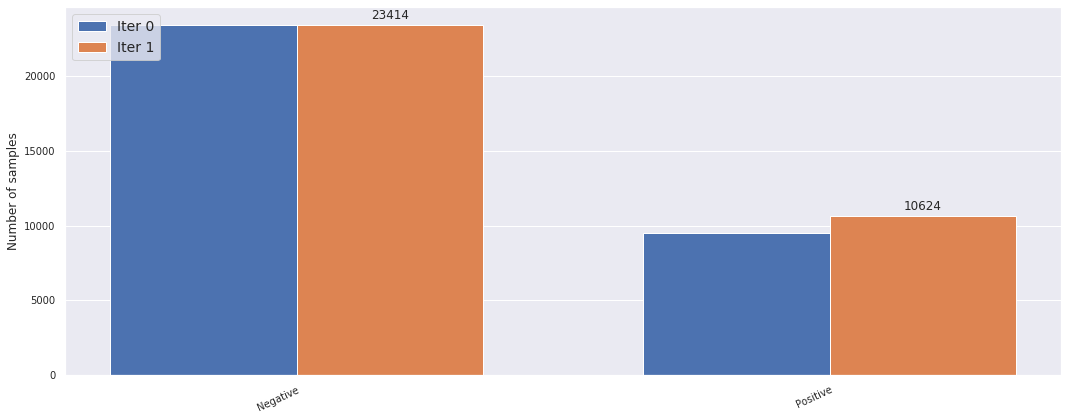


#### 0_student ####


---- Ratios before resampling ---- 
[0.68787825 0.31212175]

---- Ratios after resampling ----
[0.49326172 0.5067383 ]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)      

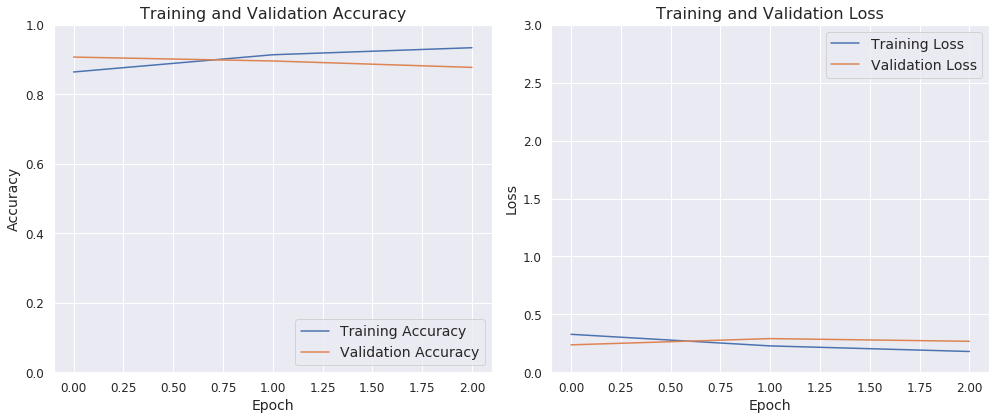

441/441 - 5s - loss: 0.2768 - sparse_categorical_accuracy: 0.8727
7063/7063 [==============================] - 4s 623us/sample
              precision    recall  f1-score   support

    Negative      0.973     0.844     0.904      5018
    Positive      0.711     0.943     0.811      2045

    accuracy                          0.873      7063
   macro avg      0.842     0.894     0.858      7063
weighted avg      0.897     0.873     0.877      7063



Press 'Interrupt Kernel' to save and exit.


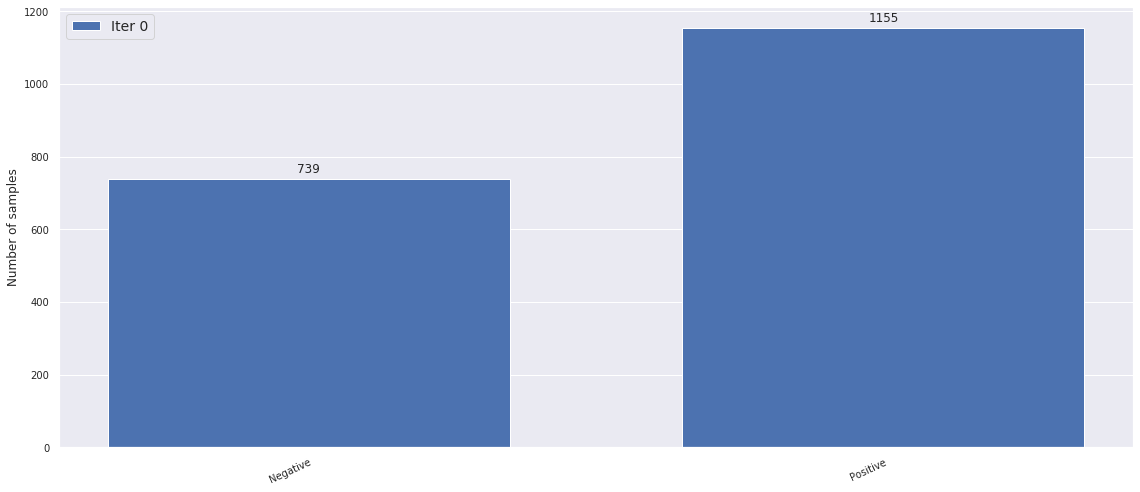


Total run time: 1.9 min.
Found 1894 new samples in unlabeled_ds after looking at 4001 images.
Limit set by Negative with 23414 samples
----------------------------------------
Negative                   : added 0/739 samples.
Positive                   : added 1155/1155 samples.


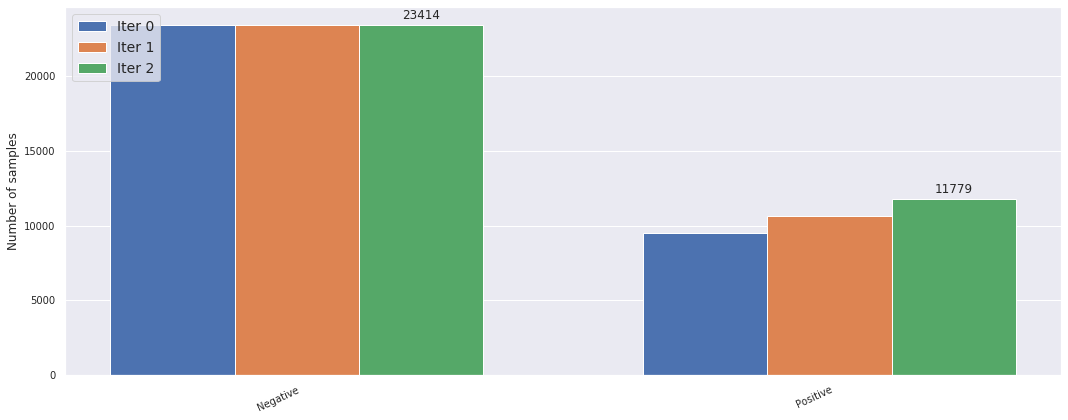

In [5]:
sanity = []

for idx, curr_model in enumerate(models_list):
    iteration = int((np.floor(idx/2.0)))   # 0,0,1,1 etc
    dir_name = str(iteration)+'_'+curr_model["name"]
    print ("\n#### {} ####\n".format(dir_name))
    conf["log_dir"] = "./logs/{}/{}".format(project_time, dir_name)
    
    # Update model hyper-parameters
    for (key, value) in curr_model.items():
        conf[key] = value
    
    # Prepare the dataset
    if idx is 0:
        # First iteration only - create dataset
        ds = create_dataset(conf)
        ds["unlab"] = create_unlab_ds(conf)
        datasets_bin = [tf_bincount(ds["clean_train"], conf["num_classes"])]
        ds["combined_train"] = ds["clean_train"]
    else:
        # refresh training data
        ds["train"] = prepare_for_training(
            ds=ds["combined_train"], 
            ds_name='train_'+dir_name,
            conf=conf,
            cache=True
        )
    
    run_iteration(conf, ds, datasets_bin, sanity)